In [21]:
!pip install gradient-descent-the-ultimate-optimizer

In [22]:
import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from gradient_descent_the_ultimate_optimizer import gdtuo


In [23]:
class MNIST_FullyConnected(nn.Module):
    def __init__(self, num_inp, num_hid, num_out):
        super(MNIST_FullyConnected, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_out)

    def initialize(self):
        nn.init.kaiming_uniform_(self.layer1.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer2.weight, a=math.sqrt(5))

    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = F.log_softmax(x, dim=1)
        return x



In [24]:
def train_with_optimizer(model_wrapper, dl_train, epochs, device):
    losses = []

    for epoch in range(1, epochs + 1):
        running_loss = 0.0

        for features_, labels_ in dl_train:
            model_wrapper.begin()

            features, labels = torch.reshape(features_, (-1, 28 * 28)).to(device), labels_.to(device)
            pred = model_wrapper.forward(features)
            loss = F.nll_loss(pred, labels)

            model_wrapper.zero_grad()
            loss.backward(create_graph=True)
            model_wrapper.step()

            running_loss += loss.item() * features_.size(0)

        train_loss = running_loss / len(dl_train.dataset)
        losses.append(train_loss)
        if epoch == epochs:
            print("EPOCH: {}, TRAIN LOSS: {:.4f}".format(epoch, train_loss))

    return losses


In [25]:
def plot_losses(losses, optimizer_labels, title):
    for idx, optimizer_label in enumerate(optimizer_labels):
        plt.plot(range(1, EPOCHS + 1), losses[idx], label=optimizer_label)

    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title(title)
    plt.legend()
    plt.show()



EPOCH: 5, TRAIN LOSS: 1.2917
Experiment completed for optimizer: gdtuo.SGD()
EPOCH: 5, TRAIN LOSS: 0.9855
Experiment completed for optimizer: gdtuo.SGD(optimizer=gdtuo.SGD())
EPOCH: 5, TRAIN LOSS: 1.0048
Experiment completed for optimizer: gdtuo.SGD(optimizer=gdtuo.Adam(0.1))
EPOCH: 5, TRAIN LOSS: 0.8918
Experiment completed for optimizer: gdtuo.Adam()
EPOCH: 5, TRAIN LOSS: 0.8350
Experiment completed for optimizer: gdtuo.Adam(optimizer=gdtuo.Adam())
EPOCH: 5, TRAIN LOSS: 0.8461
Experiment completed for optimizer: gdtuo.Adam(optimizer=gdtuo.SGD(1e-5))


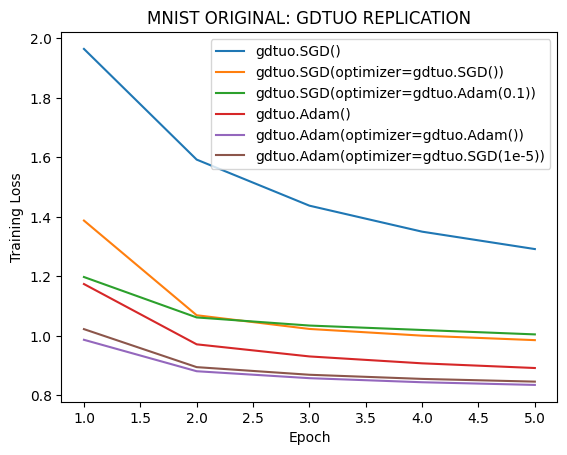

In [26]:
BATCH_SIZE = 256
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
dl_train = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)

# GDTUO Optimizers
optimizers_gdtuo = [
    gdtuo.SGD(),
    gdtuo.SGD(optimizer=gdtuo.SGD()),
    gdtuo.SGD(optimizer=gdtuo.Adam(0.1)),
    gdtuo.Adam(),
    gdtuo.Adam(optimizer=gdtuo.Adam()),
    gdtuo.Adam(optimizer=gdtuo.SGD(1e-5)),
]

optimizer_labels_gdtuo = [
    "gdtuo.SGD()",
    "gdtuo.SGD(optimizer=gdtuo.SGD())",
    "gdtuo.SGD(optimizer=gdtuo.Adam(0.1))",
    "gdtuo.Adam()",
    "gdtuo.Adam(optimizer=gdtuo.Adam())",
    "gdtuo.Adam(optimizer=gdtuo.SGD(1e-5))"
]

# Training with GDTUO Optimizers
losses_gdtuo = []

for idx, optimizer in enumerate(optimizers_gdtuo):
    model = MNIST_FullyConnected(28 * 28, 128, 10).to(DEVICE)
    mw = gdtuo.ModuleWrapper(model, optimizer=optimizer)
    mw.initialize()

    optimizer_label = optimizer_labels_gdtuo[idx]
    current_losses = train_with_optimizer(mw, dl_train, EPOCHS, DEVICE)
    losses_gdtuo.append(current_losses)
    print(f"Experiment completed for optimizer: {optimizer_label}")

plot_losses(losses_gdtuo, optimizer_labels_gdtuo, "MNIST ORIGINAL: GDTUO REPLICATION")



In [27]:
def train_with_optimizer_torch(model, optimizer, dl_train, epochs, device):
    losses = []

    for epoch in range(1, epochs + 1):
        running_loss = 0.0

        for features_, labels_ in dl_train:
            features, labels = torch.reshape(features_, (-1, 28 * 28)).to(device), labels_.to(device)

            optimizer.zero_grad()

            pred = model(features)
            loss = F.nll_loss(pred, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features_.size(0)

        train_loss = running_loss / len(dl_train.dataset)
        losses.append(train_loss)
        if epoch == epochs:
            print("EPOCH: {}, TRAIN LOSS: {:.4f}".format(epoch, train_loss))

    return losses




EPOCH: 5, TRAIN LOSS: 1.2886
Experiment completed for optimizer: SGD
EPOCH: 5, TRAIN LOSS: 0.8519
Experiment completed for optimizer: Adam


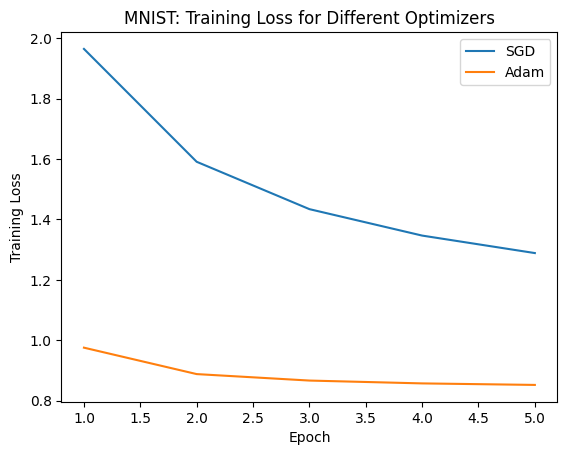

In [28]:
# Torch Optimizers
optimizers_torch = [
    torch.optim.SGD,
    torch.optim.Adam,
]

optimizer_labels_torch = [
    "SGD",
    "Adam",
]

# Training with Torch Optimizers
losses_torch = []

for idx, optimizer_fn in enumerate(optimizers_torch):
    model = MNIST_FullyConnected(28 * 28, 128, 10).to(DEVICE)
    optimizer = optimizer_fn(model.parameters(), lr=0.01)

    optimizer_label = optimizer_labels_torch[idx]
    current_losses = train_with_optimizer_torch(model, optimizer, dl_train, EPOCHS, DEVICE)
    losses_torch.append(current_losses)
    print(f"Experiment completed for optimizer: {optimizer_label}")

plot_losses(losses_torch, optimizer_labels_torch, "MNIST: Training Loss for Different Optimizers")


100%|██████████| 169001437/169001437 [00:05<00:00, 28707939.28it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
EPOCH: 5, TRAIN LOSS: 4.3556, optimizer: sgd / 
EPOCH: 5, TRAIN LOSS: 4.3009, optimizer: sgd / sgd / 
EPOCH: 5, TRAIN LOSS: 4.2113, optimizer: sgd / adam / 
EPOCH: 5, TRAIN LOSS: 3.9500, optimizer: adam / 
EPOCH: 5, TRAIN LOSS: 4.0369, optimizer: adam / adam / 
EPOCH: 5, TRAIN LOSS: 4.0403, optimizer: adam / sgd / 


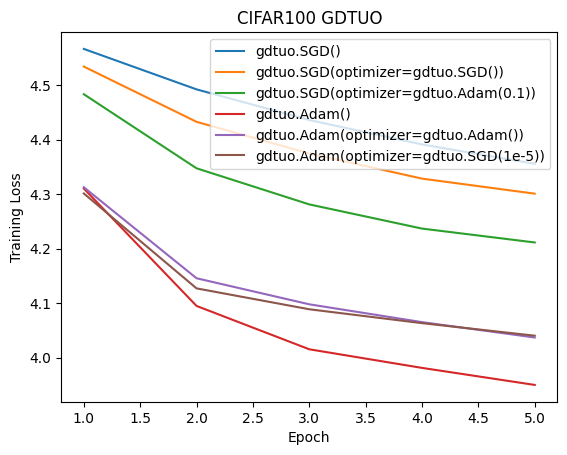

In [29]:

class CIFAR100_FullyConnected(nn.Module):
    """
    A fully-connected NN for the CIFAR-100 task. This is Optimizable but not itself an optimizer.
    """
    def __init__(self, num_inp, num_hid, num_out):
        super(CIFAR100_FullyConnected, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_out)

    def initialize(self):
        nn.init.kaiming_uniform_(self.layer1.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer2.weight, a=math.sqrt(5))

    def forward(self, x):
        """Compute a prediction."""
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = F.log_softmax(x, dim=1)
        return x


BATCH_SIZE = 256
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

cifar100_train = torchvision.datasets.CIFAR100('./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
cifar100_test = torchvision.datasets.CIFAR100('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Create data loaders for training and testing
dl_train = torch.utils.data.DataLoader(cifar100_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(cifar100_test, batch_size=10000, shuffle=False)


from gradient_descent_the_ultimate_optimizer import gdtuo

optimizers = [
    gdtuo.SGD(),
    gdtuo.SGD(optimizer=gdtuo.SGD()),
    gdtuo.SGD(optimizer=gdtuo.Adam(0.1)),
    gdtuo.Adam(),
    gdtuo.Adam(optimizer=gdtuo.Adam()),
    gdtuo.Adam(optimizer=gdtuo.SGD(1e-5)),
]

optimizer_labels=[
    "gdtuo.SGD()",
    "gdtuo.SGD(optimizer=gdtuo.SGD())",
    "gdtuo.SGD(optimizer=gdtuo.Adam(0.1))",
    "gdtuo.Adam()",
    "gdtuo.Adam(optimizer=gdtuo.Adam())",
    "gdtuo.Adam(optimizer=gdtuo.SGD(1e-5))"
]

losses = [[] for _ in optimizers]  # Store losses for each optimizer

for idx, optimizer in enumerate(optimizers):
    model = CIFAR100_FullyConnected(3 * 32 * 32, 128, 100).to(DEVICE)

    mw = gdtuo.ModuleWrapper(model, optimizer=optimizer)
    mw.initialize()

    for i in range(1, EPOCHS + 1):
        running_loss = 0.0
        for j, (features_, labels_) in enumerate(dl_train):
            mw.begin()
            features, labels = torch.reshape(features_, (-1, 3*32 * 32)).to(DEVICE), labels_.to(DEVICE)
            pred = mw.forward(features)
            loss = F.nll_loss(pred, labels)
            mw.zero_grad()
            loss.backward(create_graph=True)
            mw.step()
            running_loss += loss.item() * features_.size(0)

        train_loss = running_loss / len(dl_train.dataset)
        losses[idx].append(train_loss)
        if i == EPOCHS:
          print("EPOCH: {}, TRAIN LOSS: {:.4f}, optimizer: {}".format(i, train_loss, str(optimizer)))

# Plot training losses
for idx, optimizer in enumerate(optimizer_labels):
    plt.plot(range(1, EPOCHS + 1), losses[idx], label=str(optimizer))

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("CIFAR100 GDTUO")
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
EPOCH: 10, TRAIN LOSS: 4.5225, optimizer: SGD(lr=0.001)
EPOCH: 10, TRAIN LOSS: 4.2544, optimizer: SGD(lr=0.001, momentum=0.9)
EPOCH: 10, TRAIN LOSS: 3.8981, optimizer: Adam(lr=0.001)


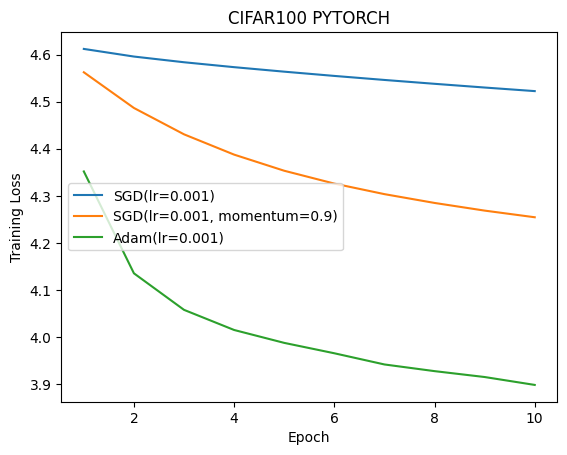

In [30]:

BATCH_SIZE = 256
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

cifar100_train = torchvision.datasets.CIFAR100('./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
cifar100_test = torchvision.datasets.CIFAR100('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Create data loaders for training and testing
dl_train = torch.utils.data.DataLoader(cifar100_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(cifar100_test, batch_size=10000, shuffle=False)

optimizers = [
    ("SGD(lr=0.001)", torch.optim.SGD, {}),
    ("SGD(lr=0.001, momentum=0.9)", torch.optim.SGD, {'momentum': 0.9}),
    ("Adam(lr=0.001)", torch.optim.Adam, {})
]

losses = [[] for _ in optimizers]

for opt_label, opt_class, opt_kwargs in optimizers:
    model = CIFAR100_FullyConnected(3 * 32 * 32, 128, 100).to(DEVICE)
    model.initialize()
    optimizer = opt_class(model.parameters(), lr=0.001, **opt_kwargs)

    for epoch in range(1, EPOCHS + 1):
        model.train()
        total_loss = 0.0
        for features_, labels_ in dl_train:
            features, labels = torch.reshape(features_, (-1, 3*32*32)).to(DEVICE), labels_.to(DEVICE)
            optimizer.zero_grad()
            output = model(features)
            loss = F.nll_loss(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * features.size(0)

        epoch_loss = total_loss / len(dl_train.dataset)
        losses[optimizers.index((opt_label, opt_class, opt_kwargs))].append(epoch_loss)
        if epoch == EPOCHS:
            print("EPOCH: {}, TRAIN LOSS: {:.4f}, optimizer: {}".format(epoch, epoch_loss, opt_label))

# Plot training losses
for idx, (opt_label, _, _) in enumerate(optimizers):
    plt.plot(range(1, EPOCHS + 1), losses[idx], label=opt_label)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("CIFAR100 PYTORCH")
plt.legend()
plt.show()


## SEMI SUPERVISED DATASET

Optimizer: 'torch.optim.sgd.SGD', Epoch: 1, Training Loss: 1.0880
Optimizer: 'torch.optim.sgd.SGD', Epoch: 2, Training Loss: 1.0840
Optimizer: 'torch.optim.sgd.SGD', Epoch: 3, Training Loss: 1.0801
Optimizer: 'torch.optim.sgd.SGD', Epoch: 4, Training Loss: 1.0762
Optimizer: 'torch.optim.sgd.SGD', Epoch: 5, Training Loss: 1.0735
Optimizer: 'torch.optim.sgd.SGD', Epoch: 6, Training Loss: 1.0711
Optimizer: 'torch.optim.sgd.SGD', Epoch: 7, Training Loss: 1.0672
Optimizer: 'torch.optim.sgd.SGD', Epoch: 8, Training Loss: 1.0660
Optimizer: 'torch.optim.sgd.SGD', Epoch: 9, Training Loss: 1.0623
Optimizer: 'torch.optim.sgd.SGD', Epoch: 10, Training Loss: 1.0605
Optimizer: 'torch.optim.adam.Adam', Epoch: 1, Training Loss: 1.1637
Optimizer: 'torch.optim.adam.Adam', Epoch: 2, Training Loss: 1.0988
Optimizer: 'torch.optim.adam.Adam', Epoch: 3, Training Loss: 1.0477
Optimizer: 'torch.optim.adam.Adam', Epoch: 4, Training Loss: 1.0227
Optimizer: 'torch.optim.adam.Adam', Epoch: 5, Training Loss: 1.0092

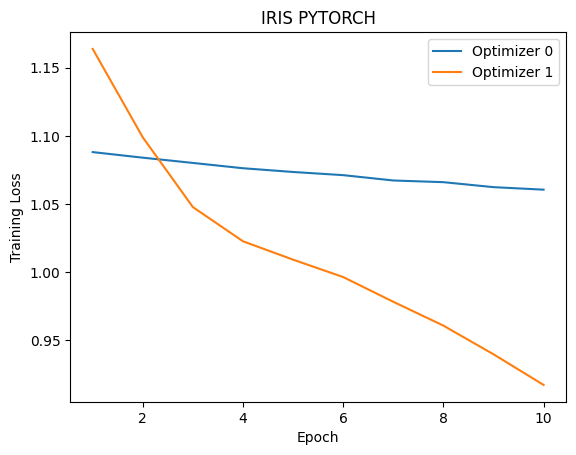

In [31]:

# Set the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset into labeled and unlabeled portions (e.g., 20% labeled, 80% unlabeled)
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.8, random_state=42)

# Convert to PyTorch tensors
X_labeled = torch.tensor(X_labeled, dtype=torch.float32)
y_labeled = torch.tensor(y_labeled, dtype=torch.long)
X_unlabeled = torch.tensor(X_unlabeled, dtype=torch.float32)

# Create a PyTorch DataLoader for labeled data
BATCH_SIZE = 16
labeled_dataset = TensorDataset(X_labeled, y_labeled)
labeled_loader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the model for CIFAR-100 dataset
class CIFAR100_FullyConnected(nn.Module):
    def __init__(self, num_inp, num_hid, num_out):
        super(CIFAR100_FullyConnected, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_out)

    def initialize(self):
        for layer in [self.layer1, self.layer2]:
            nn.init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = F.log_softmax(x, dim=1)
        return x

# Initialize model and optimizer
EPOCHS = 10
all_losses = []

optimizers = [
    torch.optim.SGD,
    torch.optim.Adam
]

for optimizer_class in optimizers:
    model = CIFAR100_FullyConnected(4, 8, 3).to(DEVICE)
    optimizer = optimizer_class(model.parameters(), lr=0.01)
    optimizer_labels = str(optimizer_class).split()[1][:-1]
    model.initialize()  # Initialize the model parameters

    losses = []
    for epoch in range(1, EPOCHS + 1):
        running_loss = 0.0
        for j, (features, labels) in enumerate(labeled_loader):
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            pred = model(features)
            loss = F.nll_loss(pred, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)

        train_loss = running_loss / len(labeled_loader.dataset)
        losses.append(train_loss)
        print("Optimizer: {}, Epoch: {}, Training Loss: {:.4f}".format(optimizer_labels, epoch, train_loss))

    all_losses.append(losses)

# Plot training losses
for idx, losses in enumerate(all_losses):
    plt.plot(range(1, EPOCHS + 1), losses, label=f"Optimizer {idx}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("IRIS PYTORCH")
plt.legend()
plt.show()


EPOCH: 10, TRAIN LOSS: 0.7942, optimizer: sgd / 
EPOCH: 10, TRAIN LOSS: 0.5535, optimizer: adam / 


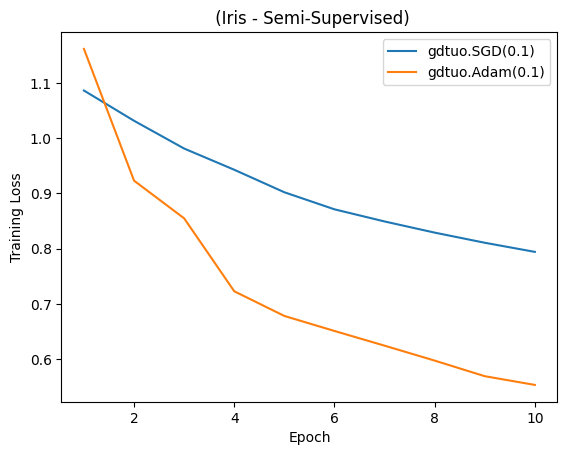

In [32]:
# resistance to bad learning rates, gdtuo is superior, more smooth curve



class Iris_FullyConnected(nn.Module):
    def __init__(self, num_inp, num_hid, num_out):
        super(Iris_FullyConnected, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_out)

    def initialize(self):
        nn.init.kaiming_uniform_(self.layer1.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer2.weight, a=math.sqrt(5))

    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = F.log_softmax(x, dim=1)
        return x

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset into labeled and unlabeled portions (e.g., 20% labeled, 80% unlabeled)
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.8, random_state=42)

# Convert to PyTorch tensors
X_labeled = torch.tensor(X_labeled, dtype=torch.float32)
y_labeled = torch.tensor(y_labeled, dtype=torch.long)
X_unlabeled = torch.tensor(X_unlabeled, dtype=torch.float32)

BATCH_SIZE = 16
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


# Define optimizers and labels
optimizers = [
    gdtuo.SGD(0.1),
    # gdtuo.SGD(optimizer=gdtuo.SGD()),
    # gdtuo.SGD(optimizer=gdtuo.Adam()),
    gdtuo.Adam(0.1),
    # gdtuo.Adam(optimizer=gdtuo.Adam()),
    # gdtuo.Adam(optimizer=gdtuo.SGD(1e-5)),
]

optimizer_labels = [
    "gdtuo.SGD(0.1)",
    # "gdtuo.SGD(optimizer=gdtuo.SGD())",
    # "gdtuo.SGD(optimizer=gdtuo.Adam())",
    "gdtuo.Adam(0.1)",
    # "gdtuo.Adam(optimizer=gdtuo.Adam())",
    # "gdtuo.Adam(optimizer=gdtuo.SGD(1e-5))"
]

losses = [[] for _ in optimizers]  # Store losses for each optimizer

for idx, optimizer in enumerate(optimizers):
    model = Iris_FullyConnected(4, 8, 3).to(DEVICE)
    mw = gdtuo.ModuleWrapper(model, optimizer=optimizer)
    mw.initialize()

    for i in range(1, EPOCHS + 1):
        running_loss = 0.0
        for j in range(0, len(X_labeled), BATCH_SIZE):
            mw.begin()
            X_batch = X_labeled[j:j+BATCH_SIZE].to(DEVICE)
            y_batch = y_labeled[j:j+BATCH_SIZE].to(DEVICE)
            pred = mw.forward(X_batch)
            loss = F.nll_loss(pred, y_batch)
            mw.zero_grad()
            loss.backward(create_graph=True)
            mw.step()
            running_loss += loss.item() * len(X_batch)

        train_loss = running_loss / len(X_labeled)
        losses[idx].append(train_loss)
        if i == EPOCHS:
          print("EPOCH: {}, TRAIN LOSS: {:.4f}, optimizer: {}".format(i, train_loss, str(optimizer)))

# Plot training losses
for idx, optimizer in enumerate(optimizer_labels):
    plt.plot(range(1, EPOCHS + 1), losses[idx], label=str(optimizer))

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(" (Iris - Semi-Supervised)")
plt.legend()
plt.show()